### <center> Wk4  NLP Text Classification using RNN Models

GitHub Https:  https://github.com/wayne-ck19/CSCA_5642.git : File name: <font color='blue'> wk4_RNN_TextClassification

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

### 1 Data EDA
#### 1.1 EDA

In [3]:
url = '.\\nlp-getting-started'
path_train = os.path.join(url, 'train.csv')
path_test = os.path.join(url, 'test.csv')

In [10]:
df_train = pd.read_csv(path_train, header = 0)
df_test = pd.read_csv(path_test, header = 0)

In [5]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
class_count = df_train['target'].value_counts()

Text(0, 0.5, 'Class Counts')

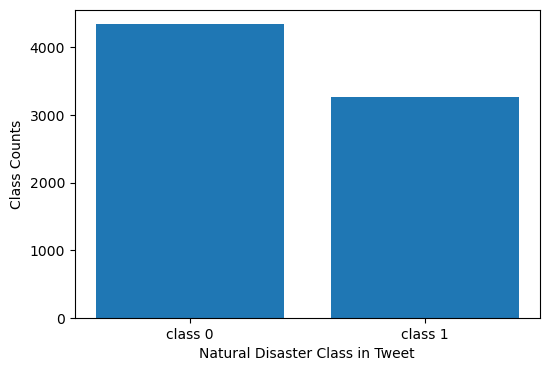

In [9]:
fig1 = plt.figure(figsize = (6,4))
plt.bar([f'class {class_count.index[0]}', f'class {class_count.index[1]}'], class_count)
plt.xlabel('Natural Disaster Class in Tweet')
plt.ylabel('Class Counts')

#### 1.2 Count the unique words for an estimate of tokenizer vocabulary

In [44]:
sr_wordbag = df_train['text'].apply(lambda x:x.split())

In [46]:
bag_of_words = []
null_ = sr_wordbag.apply(lambda x:bag_of_words.extend(x))

In [49]:
set_of_words = set(bag_of_words)

In [50]:
len(bag_of_words)

113461

In [54]:
number_of_unique_words = len(set_of_words)
print(f'The number of total unique words = {number_of_unique_words}')

The number of total unique words = 31924


In [60]:
### find out what is maximum length of each tweet

text_length = np.vectorize(len)(df_train['text'].to_numpy())
max_text_length = np.max(text_length)
print(f'The maximum length of tweets = {max_text_length}')

The maximum length of tweets = 157


### 2 Preprocessing

#### 2.1 Input Pipeline 

##### 2.1.1 Tensorflow tf.data.Dataset

In [38]:
def input_pipeline(tr_df, ts_df, buffersize = 64, batchsize = 32):
    tr_text = tr_df['text'].to_numpy()
    tr_label = tr_df['target'].to_numpy()
    ts_text = ts_df['text'].to_numpy()

    X_train, X_valid, y_train, y_valid = train_test_split(tr_text, tr_label, test_size = 0.2, random_state = 40, stratify = tr_label)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))    
    test_dataset = tf.data.Dataset.from_tensor_slices(ts_text)

    # set up batch and buffer for dataset

    train_dataset = train_dataset.shuffle(buffer_size = buffersize).batch(batchsize).prefetch(tf.data.AUTOTUNE)
    valid_dataset = valid_dataset.shuffle(buffer_size = buffersize).batch(batchsize).prefetch(tf.data.AUTOTUNE)
    token_dataset = train_dataset.map(lambda text, label:text)
    test_dataset = test_dataset.batch(batchsize).prefetch(tf.data.AUTOTUNE)

    return train_dataset, valid_dataset, token_dataset, test_dataset

In [39]:
dataset_train, dataset_valid, dataset_token, dataset_test = input_pipeline(df_train, df_test)

##### 2.1.2 Check the datasets

In [26]:
sample_tuple = list(dataset_train.take(1).as_numpy_iterator())[0]

In [29]:
sample_text = sample_tuple[0]
sample_text.shape
sample_target = sample_tuple[1]

In [28]:
sample_text[10]

b'Obama Declares Disaster for Typhoon-Devastated Saipan http://t.co/CanEyTtwEV #international'

In [31]:
sample_target[10]

1

In [42]:
sample_for_token = list(dataset_token.take(1).as_numpy_iterator())[0]
print(sample_for_token[10])

b"investigate why Robert mueller didn't respond to my complaints since Nov 2011 &amp; just left me/son out her in danger http://t.co/pe2D3HCsNI"


In [43]:
sample_test = list(dataset_test.take(1).as_numpy_iterator())[0]
print(sample_test[10])

b"No I don't like cold!"


### 3. Build a Text Tokenizer

##### 3.1 Build and Train Tokenizer

In [86]:
seq_length = int(1.2*max_text_length)
tokenizer = tf.keras.layers.TextVectorization(max_tokens = int(1.2*number_of_unique_words), output_mode = 'int', 
                                              output_sequence_length = seq_length)
tokenizer.adapt(dataset_token)

In [88]:
int(1.2*number_of_unique_words)

38308

In [89]:
tokenizer.vocabulary_size()

19351

In [69]:
tokenizer.get_vocabulary()[120]

'nuclear'

In [80]:
len(tokenizer.get_vocabulary())

19351

##### 3.2 Test a text on tokenizer

In [90]:
i = 10
text_input = list(dataset_train.take(1).as_numpy_iterator())[0][0][i:i+2]  # This will have a list of ONE tuple with two elements. Each element is a (batch,) array)

In [91]:
text_input

array([b"@Reds I don't throw the word hero around lightly... Usually reserved for first responders and military... But he's a hero...",
       b'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/c0p3SEsqWm via @usatoday'],
      dtype=object)

In [92]:
tokenizer(text_input)

<tf.Tensor: shape=(2, 188), dtype=int64, numpy=
array([[ 8541,     7,    61,  4073,     2,  1579,  1191,   318, 10504,
         1446,  8448,    10,    96,   624,     8,   223,    30,   262,
            3,  1191,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

### 4. LSTM Model Architecture and Training

#### 4.1 Model Construction

##### 4.1.1 Understanding LSTM output shape

In [81]:
## Let's test the shape of inputs and outputs for different LSTM setups
lstm_test = tf.keras.layers.LSTM(8)
lstm_test2 = tf.keras.layers.LSTM(8, return_sequences = True)
inputs = np.random.normal(size = (32, 20, 50)) # (batch, time step, feature)
output1 = lstm_test(inputs)
output2 = lstm_test2(inputs)
print(output1.shape)
print(output2.shape)

(32, 8)
(32, 20, 8)


#### Findings
LSTM assigns a LSTM gate to each time step, if return_sequences = True, the model outputs the intermediate result for each gate assigned to each time step. <br> if return_sequences = False, it will only ouptput the last step where each intermediate step goes through next following gate, and eventually all time steps are condensed

##### 4.1.2 Build the LSTM Model 

In [138]:
class LSTM_NLP(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_unit, seq_length):
        super(LSTM_NLP, self).__init__()
        self.vectorizer = tokenizer
        self.embedding = tf.keras.layers.Embedding(input_dim = tokenizer.vocabulary_size(),
                                                   output_dim = embedding_dim,
                                                   mask_zero = True,
                                                   input_length = seq_length)
                                               
        self.lstm = tf.keras.layers.LSTM(units = lstm_unit, return_sequences = False, kernel_regularizer=tf.keras.regularizers.l1_l2())  # only return last output, no intermediate sequence from each gate
        self.norm = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1_l2())
        self.dropout = tf.keras.layers.Dropout(rate = 0.6)
        self.dense2 = tf.keras.layers.Dense(1)  # the output is logits, no activation. sigmoid will be activated in binarycrossentropy()

    def call(self, inputs, training = False):
        x = self.vectorizer(inputs)
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dropout(x, training = training)
        x = self.norm(x, training = training)
        x = self.dense1(x)        
        res_logit = self.dense2(x)

        return res_logit

##### 4.1.3 Compile the Model

In [141]:
embedding_dim = 256
lstm_unit = 8
seq_length =  int(1.2*max_text_length)
model_nlp_lstm = LSTM_NLP(embedding_dim = embedding_dim, lstm_unit = lstm_unit, seq_length = seq_length)
#===============================
model_nlp_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00025), 
                       loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                       metrics = ['accuracy', tf.keras.metrics.AUC(curve= 'ROC')])

##### 4.1.4 Training the Model

In [142]:
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience = 2)
hist = model_nlp_lstm.fit(dataset_train, validation_data = dataset_valid, epochs = 10, callbacks = [lr_plateau])

Epoch 1/10
191/191 [==============================] - 16s 38ms/step - loss: 6.0521 - accuracy: 0.6056 - auc_16: 0.6484 - val_loss: 4.2757 - val_accuracy: 0.5706 - val_auc_16: 0.5138 - lr: 2.5000e-04
Epoch 2/10
191/191 [==============================] - 5s 28ms/step - loss: 2.9274 - accuracy: 0.7038 - auc_16: 0.7794 - val_loss: 1.9595 - val_accuracy: 0.6093 - val_auc_16: 0.7299 - lr: 2.5000e-04
Epoch 3/10
191/191 [==============================] - 5s 26ms/step - loss: 1.2441 - accuracy: 0.7897 - auc_16: 0.8429 - val_loss: 0.9353 - val_accuracy: 0.7689 - val_auc_16: 0.8015 - lr: 2.5000e-04
Epoch 4/10
191/191 [==============================] - 5s 25ms/step - loss: 0.7019 - accuracy: 0.8479 - auc_16: 0.8815 - val_loss: 0.7710 - val_accuracy: 0.7945 - val_auc_16: 0.8060 - lr: 2.5000e-04
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.5438 - accuracy: 0.8901 - auc_16: 0.9131 - val_loss: 0.6910 - val_accuracy: 0.7971 - val_auc_16: 0.7978 - lr: 2.5000e-04
Epoch 6/1

In [143]:
df_hist = pd.DataFrame(hist.history)

In [145]:
df_hist.columns = ['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc',
       'lr']

Text(0, 0.5, 'Metric Scores')

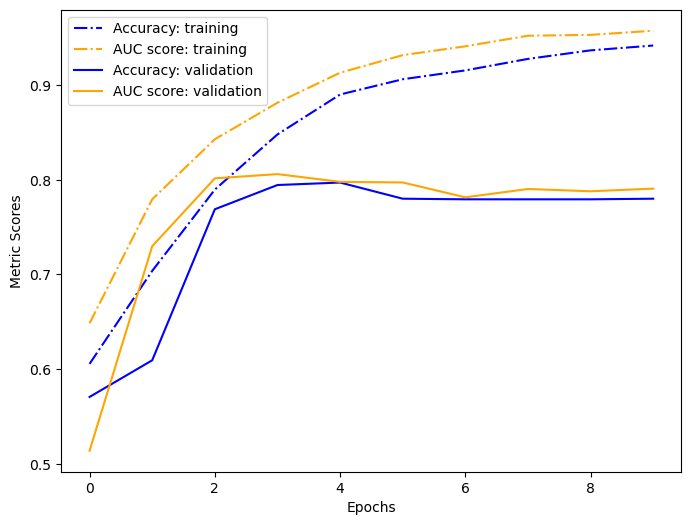

In [146]:
fig = plt.figure(figsize = (8,6))
plt.plot(df_hist['accuracy'], linestyle ='-.', color = 'blue', label = 'Accuracy: training')
plt.plot(df_hist['auc'], linestyle ='-.', color = 'orange', label = 'AUC score: training')
plt.plot(df_hist['val_accuracy'], linestyle ='-', color = 'blue', label = 'Accuracy: validation')
plt.plot(df_hist['val_auc'], linestyle ='-', color = 'orange', label = 'AUC score: validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metric Scores')

#### Findings 
* The simple LSTM model for this NLP classification problem can achieve AUC of 0.79 for validation data
* It has overfitting despite of using regularization and drop out.
* Below are the summary of hyperparameter study. The model hyperparameters have small impacts on the AUC score of the model.

| Hyperparameters   | Value    | AUC Score on Validation Data  |
| ----------- | ----------- | ----------- |
|  Embedding Dimension |   128   |   0.77  |
|  Embedding Dimension |   256   |   0.78  |
|  LSTM Unit |   8   |   0.78  |
|  LSTM Unit |   32   |   0.76  |
| Dropout rate | 0.2 |  0.77 |
| Dropout rate | 0.5 |  0.78  |

### 5. LSTM Model on Test Data

In [147]:
def lstm_predict(model, dataset_test, df_test):
    pred_logits = model.predict(dataset_test)
    prob = tf.math.sigmoid(pred_logits)
    pred = tf.cast(prob >= 0.5, tf.int32)
    pred = pred.numpy()
    df_test['target'] = pred
    return df_test[['id','target']]

In [149]:
df_pred = lstm_predict(model_nlp_lstm, dataset_test, df_test)

102/102 [==============================] - 3s 15ms/step


In [152]:
df_pred.to_csv('prediction_lstm.csv', index = False)

### 6. Conclusion on LSTM for NLP Text Classification

The above test results submitted to Kaggle received a score of 0.77, which is consistent with our obervations in validation data. Following conclusions can be drawn:

* For a simple task such as tweet text classification, LSTM can meet the needs very well.
* The hyperpameters have small impacts on the performance of LSTM. Increased text embedding dimension and LSTM unit don't necessarily improve the model performance